# DWPP test result analysis test code

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from pathlib import Path
import os



## Make reference path

In [42]:
def make_path():
    """
    Function to generate reference paths
    Returns:
        (path_A, path_B, path_C)
    """
    paths = []
    # 生成するカーブの角度パターン
    theta_list = [np.pi/4, np.pi/2, 3*np.pi/4]
    l_segment = 3.0  # 直線区間の長さパラメータ

    for theta in theta_list:
        # 1. 直進 (0 -> 1m)
        x1 = np.linspace(0, 1, 100)
        y1 = np.zeros_like(x1)
        
        # 2. 斜め直線 (角度thetaで長さl)
        # Note: 実際には直線補間だが、ここでは簡易的に生成
        x2 = np.linspace(1.0, 1.0 + l_segment * math.cos(theta), 300)
        y2 = np.linspace(0.0, l_segment * math.sin(theta), 300)
        
        # 3. 終端直進 (さらに3m進む)
        x3 = np.linspace(
            1.0 + l_segment * math.cos(theta), 
            4.0 + l_segment * math.cos(theta), 300)
        y3 = np.ones_like(x3) * l_segment * math.sin(theta)

        # 結合
        xs = np.concatenate([x1, x2, x3])
        ys = np.concatenate([y1, y2, y3])
        
        path = np.c_[xs, ys]
        
        paths.append(path)
        

    # 展開して返す
    return (paths[0], paths[1], paths[2])

PathA, PathB, PathC = make_path()


## Function

In [43]:
from scipy.spatial.distance import cdist

def calc_rmse(robot_path: np.ndarray, path: np.ndarray) -> float:

    # Compute the distances between each point on the robot trajectory and each point on the path at once (using scipy's cdist)
    # distance_matrix has shape = (number of points in the robot trajectory, number of points in the path)
    distance_matrix = cdist(robot_path, path, metric='euclidean')

    # Take the minimum along the row direction to extract the minimum distance for each robot point
    min_distances = np.min(distance_matrix, axis=1)

    # Compute RMSE
    rmse = np.sqrt(np.mean(min_distances**2))
    
    return rmse


In [44]:
def calc_violation_rate(violation_flags) -> float:
    violation_count = np.sum(violation_flags)
    total_count = len(violation_flags)
    violation_rate = violation_count / total_count
    return violation_rate

## Examine DWPP path test

[PosixPath('/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/APP_20251211_201532.csv'), PosixPath('/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/DWPP_20251211_201349.csv'), PosixPath('/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/PP_20251211_201616.csv'), PosixPath('/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/RPP_20251211_201456.csv')]
Processing file: /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/APP_20251211_201532.csv
経路追従誤差RMSE (PathC): 0.5190 m
違反率: 0.6209
Processing file: /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/DWPP_20251211_201349.csv
経路追従誤差RMSE (PathC): 0.1259 m
違反率: 0.0000
Processing file: /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/PP_20251211_201616.csv
経路追従誤差RMSE (PathC): 0.3632 m
違反率: 0.4545
Processing file: /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC/RPP_20251211_201456.csv
経路追従誤差RM

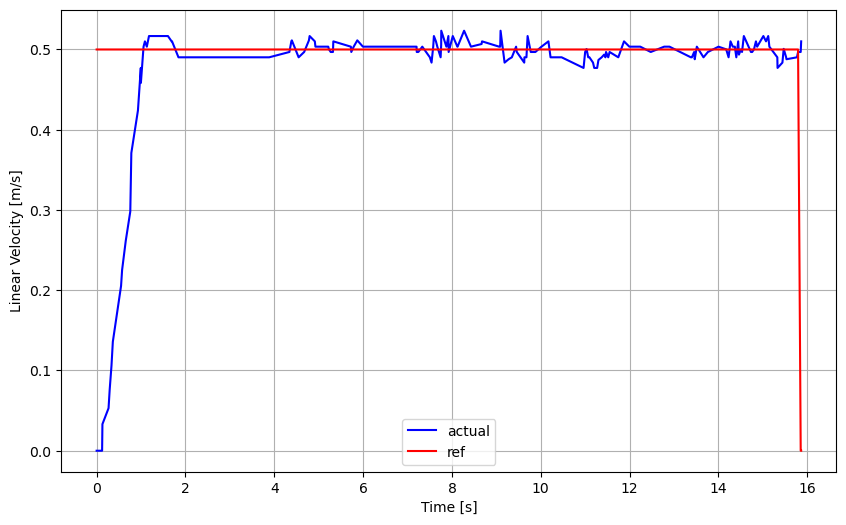

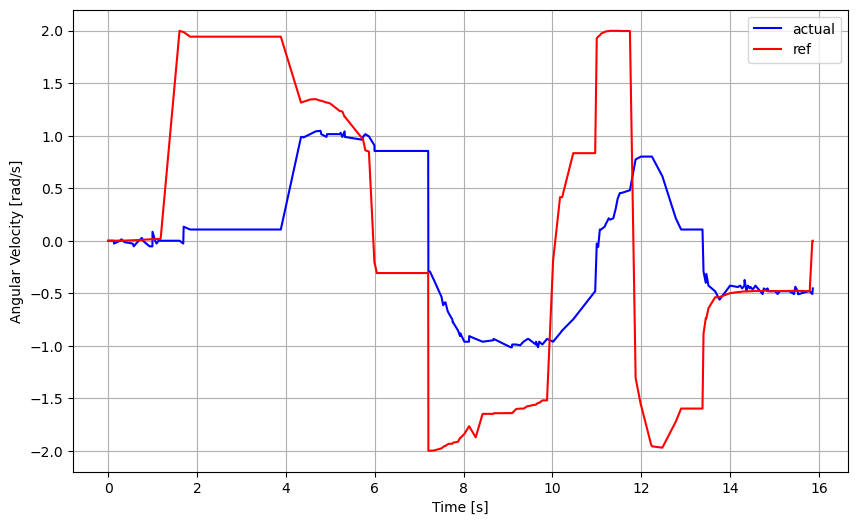

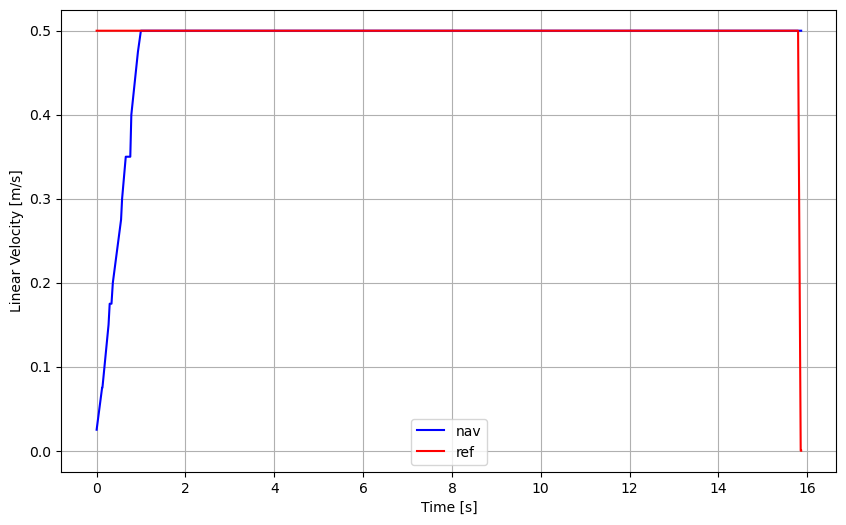

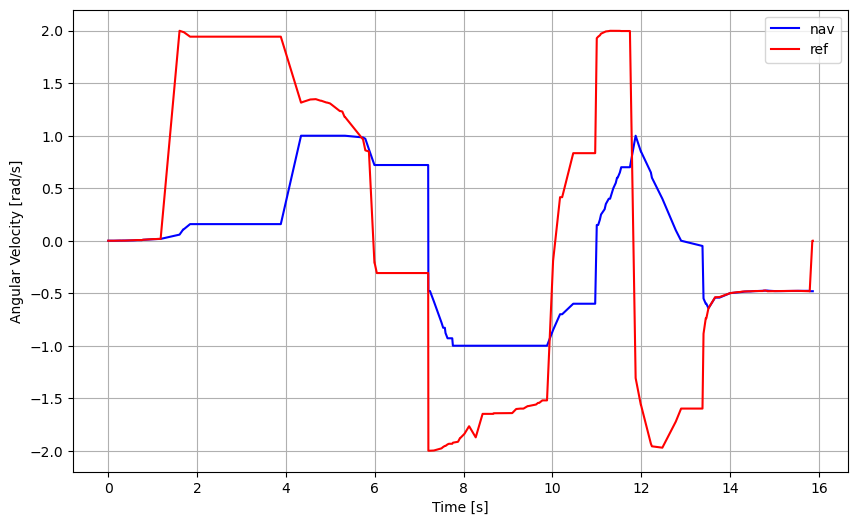

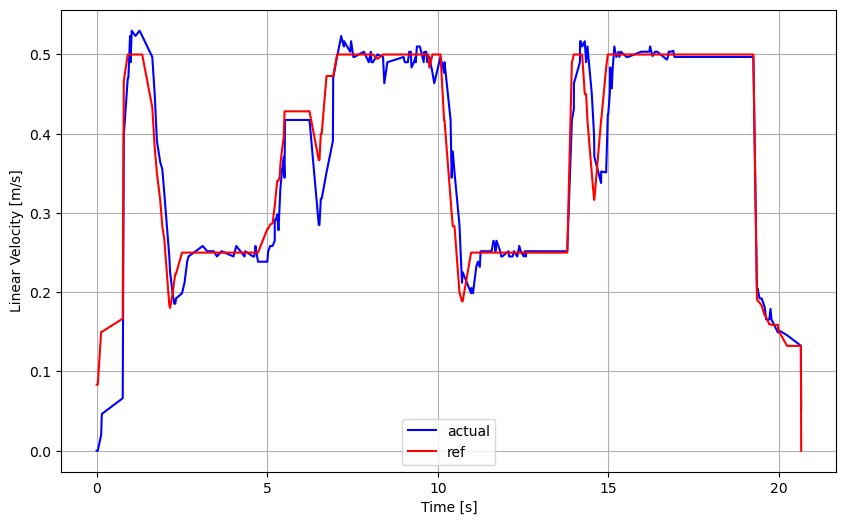

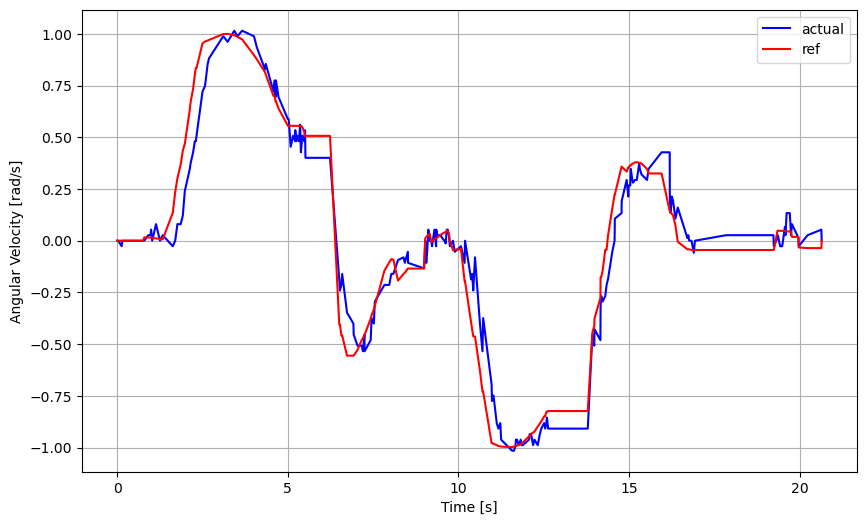

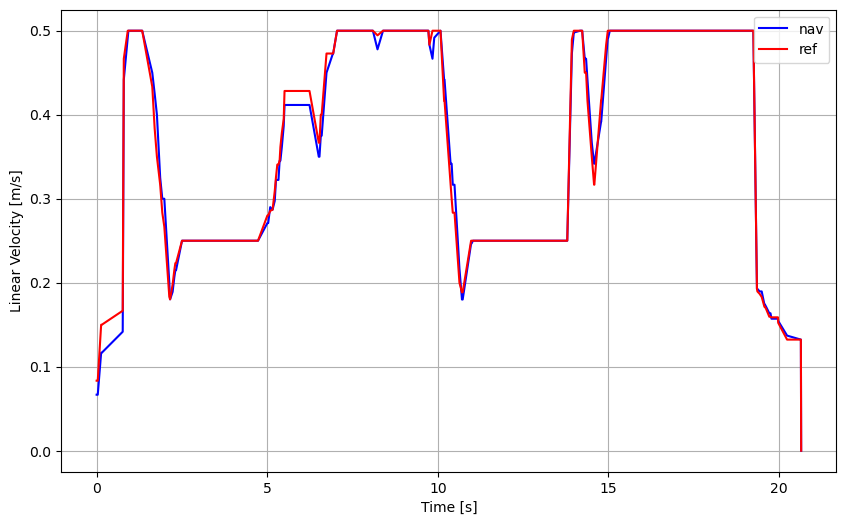

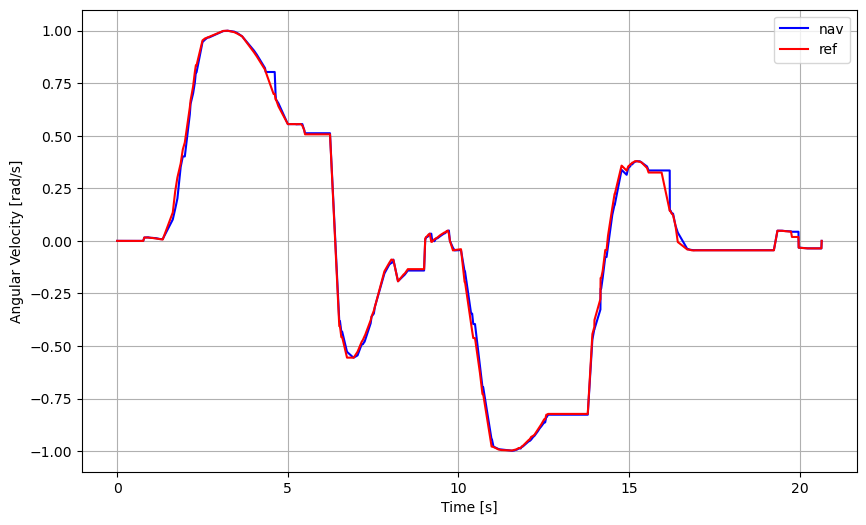

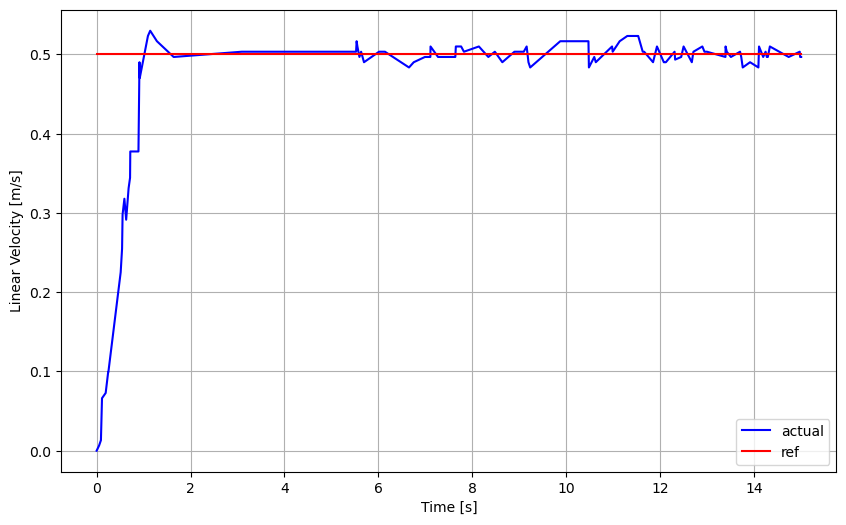

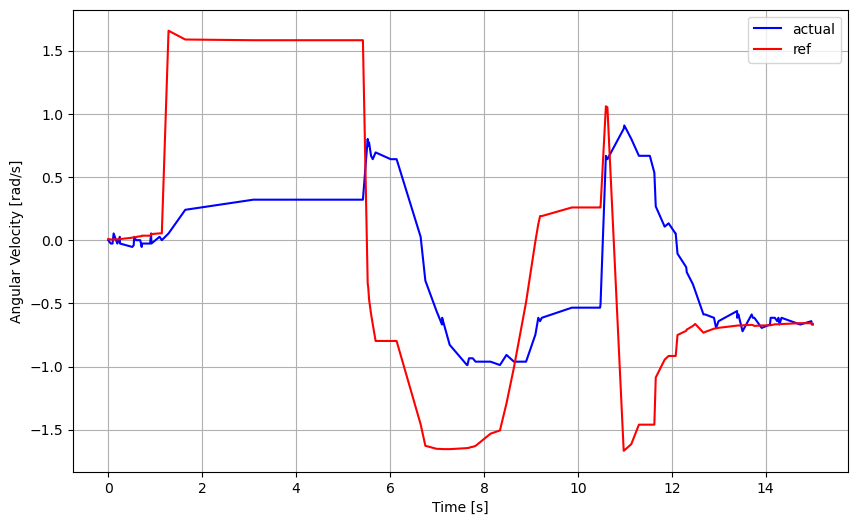

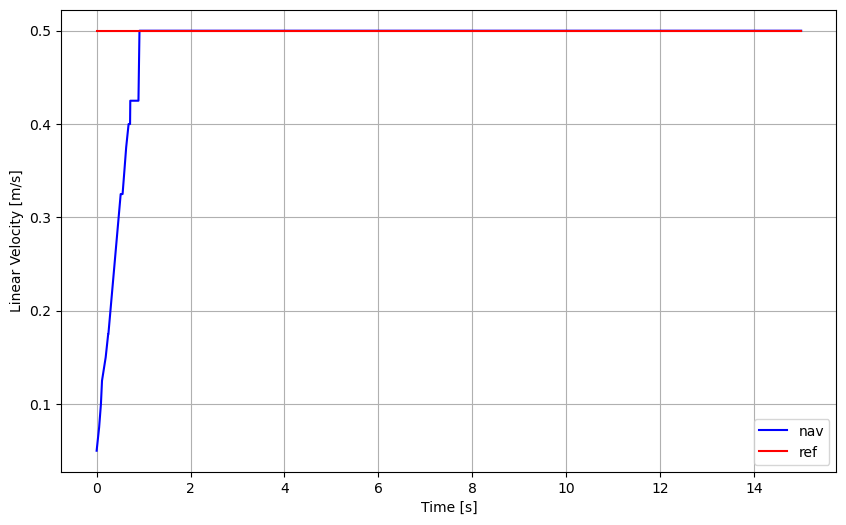

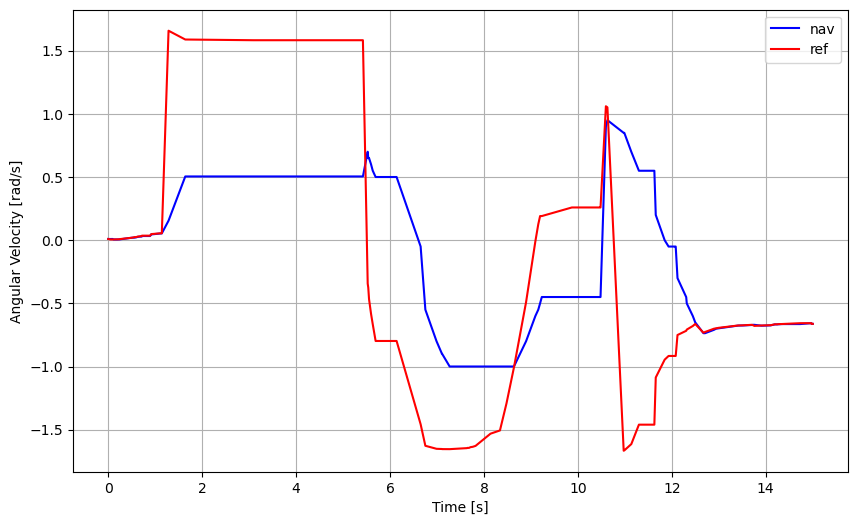

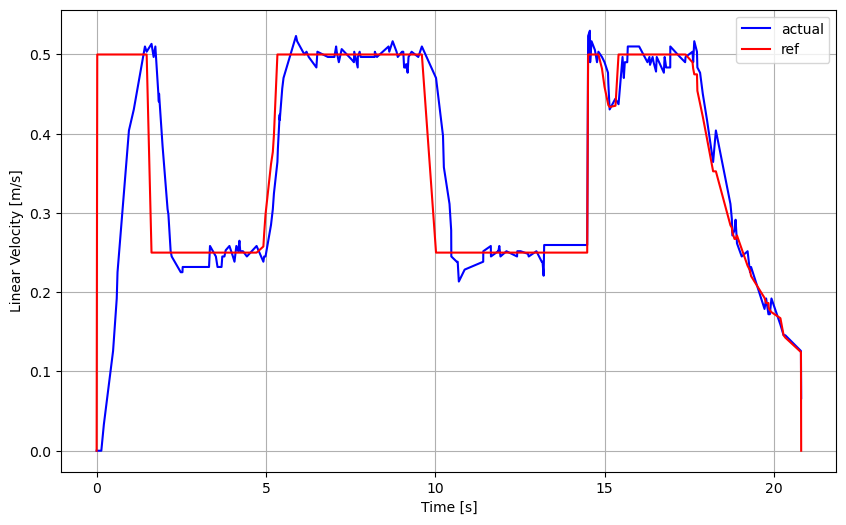

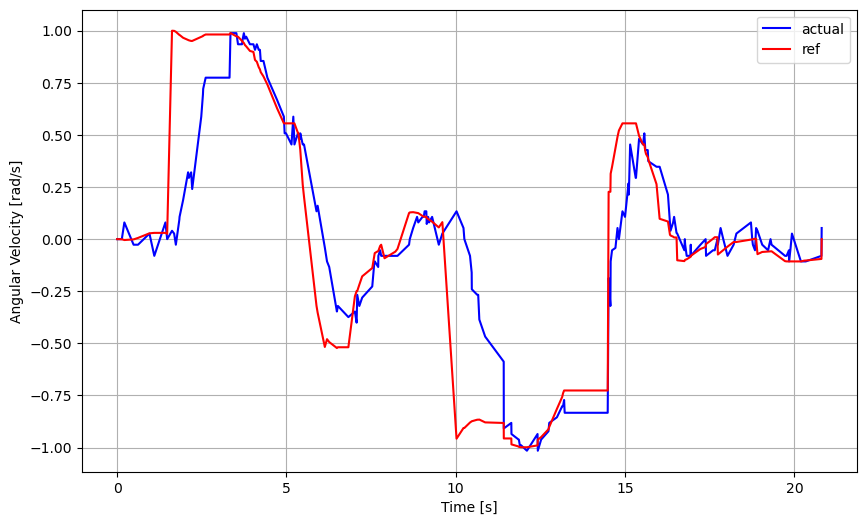

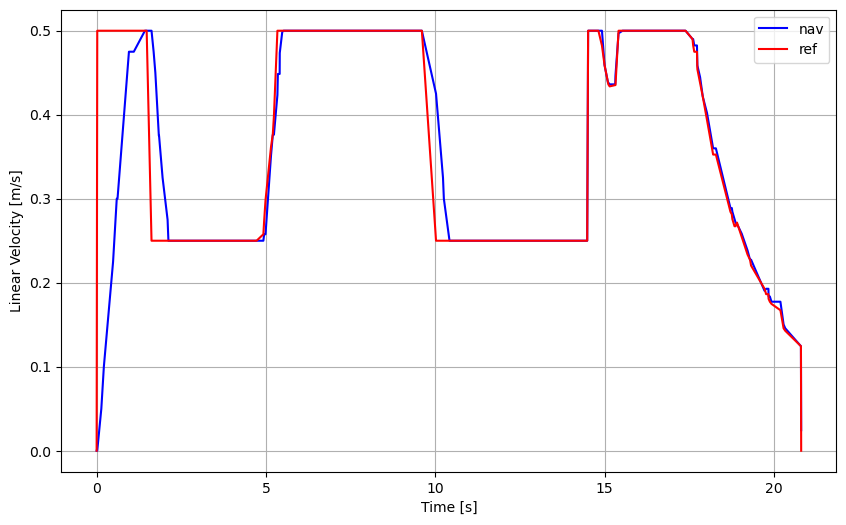

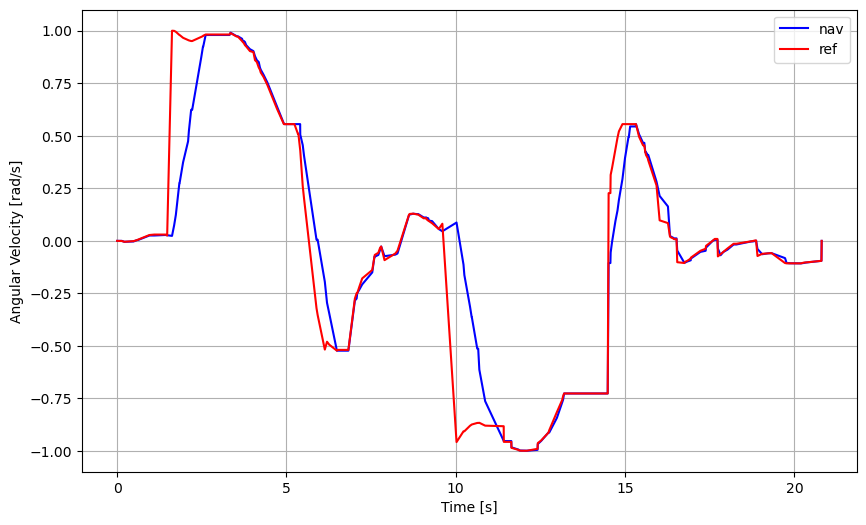

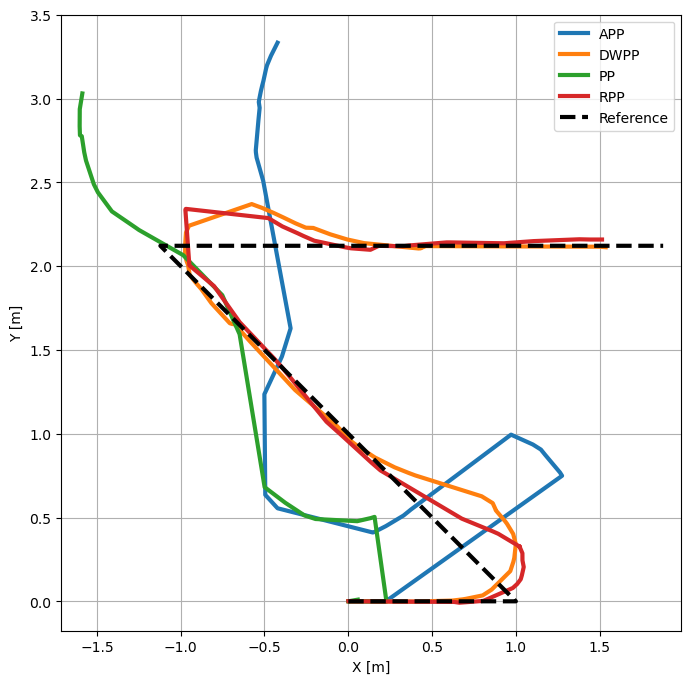

In [45]:
dir_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathC")
data_paths = sorted(dir_path.glob("*.csv"))
method_list = ["APP", "DWPP", "PP", "RPP"]
path_dict = {
    "APP": None,
    "DWPP": None,
    "PP": None,
    "RPP": None}
print(data_paths)

for filepath, method_name in zip(data_paths, method_list):
    print("Processing file:", filepath)
    df = pd.read_csv(filepath)

    # データの読み込み
    t = df["sec"].values - df["sec"].values[0]  # 開始時間を0に合わせる
    x = df["x"].values
    y = df["y"].values
    robot_path = np.c_[x, y]
    path_dict[method_name] = robot_path
    v = df["v_real"].values
    w = df["w_real"].values
    cmd_v = df["v_cmd"].values
    cmd_w = df["w_cmd"].values
    v_nav = df["v_nav"].values
    w_nav = df["w_nav"].values
    velocity_violation_flag = df["velocity_violation"].values
    
    rmse = calc_rmse(robot_path, PathC)
    violation_rate = calc_violation_rate(velocity_violation_flag)
    print(f"経路追従誤差RMSE (PathC): {rmse:.4f} m")
    print(f"違反率: {violation_rate:.4f}")
    
    # txtに書き出し
    txt_filename = os.path.dirname(filepath) + "/result.txt"
    with open(txt_filename, "a") as f:
        f.write(f"Method: {method_name}\n")
        f.write(f"RMSE: {rmse:.4f} m\n")
        f.write(f"Violation Rate: {violation_rate:.4f}\n")
        f.write("\n")

    # 速度プロファイルの図示
    plt.figure(figsize=(10, 6))
    plt.plot(t, v, label="actual", color='blue')
    plt.plot(t, cmd_v, label="ref", color='red')
    plt.xlabel("Time [s]")
    plt.ylabel("Linear Velocity [m/s]")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{os.path.dirname(filepath)}/{method_name}_real_v.png")

    plt.figure(figsize=(10, 6))
    plt.plot(t, w, label="actual", color='blue')
    plt.plot(t, cmd_w, label="ref", color='red')
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Velocity [rad/s]")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{os.path.dirname(filepath)}/{method_name}_real_w.png")
    
    plt.figure(figsize=(10, 6))
    plt.plot(t, v_nav, label="nav", color='blue')
    plt.plot(t, cmd_v, label="ref", color='red')
    plt.xlabel("Time [s]")
    plt.ylabel("Linear Velocity [m/s]")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{os.path.dirname(filepath)}/{method_name}_nav_v.png")

    plt.figure(figsize=(10, 6))
    plt.plot(t, w_nav, label="nav", color='blue')
    plt.plot(t, cmd_w, label="ref", color='red')
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Velocity [rad/s]")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{os.path.dirname(filepath)}/{method_name}_nav_w.png")

# 経路の描画
plt.figure(figsize=(8, 8))
for method_name in method_list:
    robot_path = path_dict[method_name]
    plt.plot(robot_path[:, 0], robot_path[:, 1], label=method_name, linewidth=3)
plt.plot(PathC[:, 0], PathC[:, 1], 'k--', label="Reference", linewidth=3)
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.savefig(f"{dir_path}/path_comparison.png")

In [46]:
df.head()

,sec,nsec,x,y,yaw,v_cmd,w_cmd,battery_v,battery_i,v_real,w_real,imu_ax,imu_ay,imu_az,imu_vx,imu_vy,imu_vz,v_nav,w_nav,velocity_violation
0,1.765452e+09,218379520.0,0.0,0.0,-8.673617e-19,0.0,0.000000e+00,25.200001,-0.301,0.000000,0.000000,1.228225,0.117316,9.445126,0.030626,0.023303,0.000000,0.000,0.000000e+00,False
1,1.765452e+09,236563712.0,0.0,0.0,-8.673617e-19,0.5,7.105427e-15,25.200001,-0.301,0.000000,0.000000,1.489193,0.213084,9.684546,0.007324,-0.037950,-0.001065,0.000,0.000000e+00,True
2,1.765452e+09,357000448.0,0.0,0.0,-8.673617e-19,0.5,-5.342319e-04,25.200001,-0.301,0.000000,0.000000,1.007959,0.047884,9.643844,0.029295,0.021572,-0.002929,0.050,7.105427e-15,False
3,1.765452e+09,431738880.0,0.0,0.0,-8.673617e-19,0.5,-4.285187e-03,25.200001,-0.301,0.033125,0.080139,0.811634,0.409408,9.176975,0.008522,-0.037950,0.006924,0.100,-4.279437e-03,False
4,1.765452e+09,704068864.0,0.0,0.0,-8.673617e-19,0.5,-1.216599e-03,25.200001,-0.301,0.125875,-0.026712,0.730232,-0.095768,11.626243,0.093876,0.061785,-0.023303,0.225,-2.789412e-03,False
